# LSTM and Attention


In this notebook, the goal is to perform named entity recognition using the attention model associated with LSTM.


In [1]:
import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field
from torchtext.data import NestedField
from torchtext.data import BucketIterator

from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain
import spacy

# Data Preparation 


In [2]:
#### setting seed value for subsequent repeatable sets 

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

text_data = data.Field(lower = False) 

tags = data.Field(unk_token = None) 

#### reading data files 

data_path = "data"

train_data, valid_data, test_data = data.TabularDataset.splits(
        path= data_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", text_data), ("tag", tags))
    )



In [3]:
#### setting the minimum frequency to 1 so that the words that appear less than MIN_FREQ times will be ignored from the vocabulary

MIN_FREQ = 1

#### vocabulary building

text_data.build_vocab(train_data, 
                 min_freq = MIN_FREQ, 
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)

tags.build_vocab(train_data)

####setting up batch size 

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### device = 'cpu'

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)



In [4]:
# Index padding

text_data_PAD_IDX = text_data.vocab.stoi[text_data.pad_token]
tags_PAD_IDX = tags.vocab.stoi[tags.pad_token]


# Model Building 

####  Here we have buit a class in order to build a model with layering 


The inputs (*query*, *key*, and *value*) for the attention layer are the same: the output of the LSTM.

In [5]:
class BiLSTM(nn.Module):

####Class created to built up model with desired shape and architecture.   
    
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 attn_heads,
                 emb_dropout,
                 lstm_dropout,
                 attn_dropout,
                 fc_dropout,
                 word_pad_idx,  
                 tag_pad_idx):
        super().__init__()
        
        self.word_pad_idx = word_pad_idx  
        self.tag_pad_idx = tag_pad_idx  
        
## LAYERING       
        
# LAYER 1A: Word Embedding
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        
        self.emb_dropout = nn.Dropout(emb_dropout)
        
        
# LAYER 2: BiLSTM

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
# LAYER 3: Self-attention

        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=attn_heads,
            dropout=attn_dropout
        )
    
# LAYER 4: Fully-connected
        
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        
# LAYER 5: CRF
        
        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)
        
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        
        # words = [sentence length, batch size]
        # tags = [sentence length, batch size]
        
        embedding_out = self.emb_dropout(self.embedding(words))
        
        # embedding_out = [sentence length, batch size, embedding dim]
  
        lstm_out, _ = self.lstm(embedding_out)
    
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        
        # Mask for padding 
        
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        
        
        # key_padding_mask = [batch size, sentence length]
        
        
        
       
        attn_out, attn_weight = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        
        # attn_out = [sentence length, batch size, hidden dim * 2]
        # attn_weight = [batch size, sentence length, sentence length]
        
        fc_out = self.fc(self.fc_dropout(attn_out))
        
        # fc_out = [sentence length, batch size, output dim]     
        
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc_out, mask=crf_mask)
        crf_loss = -self.crf(fc_out, tags=tags, mask=crf_mask) if tags is not None else None
        
        return crf_out, crf_loss, attn_weight

    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        
        for i in range(num_tags):
            tag_name = tag_names[i]
            
        # In starting I and pad are not possible.         
        
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
                
        # between  O - I transition is impossible
        
        tag_is = {}
        
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"

        }
        
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
                        
        # in different types, transition is impossible. 
        
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )
    
    def count_parameters(self):
    
    #### counting prameters of the model     
        
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [6]:
model = BiLSTM(
    input_dim=len(text_data.vocab),
    embedding_dim=300,
    hidden_dim=64,
    output_dim=len(tags.vocab),
    lstm_layers=2,
    attn_heads=16,
    emb_dropout=0.5,
    lstm_dropout=0.2,
    attn_dropout=0.2,
    fc_dropout=0.2,
    word_pad_idx=text_data_PAD_IDX,
    tag_pad_idx=tags_PAD_IDX
)


In [32]:
len(text_data.vocab)

23626

In [7]:
def init_weights(m):
    
#### Initializing the weights for model parameters      
    
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

In [8]:
model.apply(init_weights)

pretrained_embeddings = text_data.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[tags_PAD_IDX] = torch.zeros(300)

In [9]:
# Initialisation of CRF transitions 

model.init_crf_transitions(
    tag_names=tags.vocab.itos
)

print(f"The Model consists {model.count_parameters():,} parameters to train.")

The Model consists 7,441,978 parameters to train.


# Training 

- Optimizer and loss function



In [10]:
def optimizer(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    
#### Optimizing the model using adam optimizer with given set of parameters

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimizer(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.01, second_weight_decay_rate=0.0)

criterion = nn.CrossEntropyLoss(ignore_index = tags_PAD_IDX)

model = model.to(device)

criterion = criterion.to(device)

In [11]:
optimizer = optim.Adam(model.parameters(),  lr=1e-4)

#### Defining matrics method for comparing the results 

In [16]:
from sklearn.metrics import f1_score, classification_report

#### Computing the F1 score for predicted values

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = tags.vocab.stoi["O"]
    positive_labels = [i for i in range(len(tags.vocab.itos))
                       if i not in (tags_PAD_IDX, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    
    if full_report:
      
        positive_names = [tags.vocab.itos[i]
                              for i in range(len(tags.vocab.itos))
                              if i not in (tags_PAD_IDX, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

### Creating methods for training and evaluation 

In [17]:
#### Training the model

def train(model, iterator, optimizer, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss, _ = model(text, tags)
        
        # here we have flatten true tags in order to calculate loss and the f1 score
        
        true_tags_list = [
                [tag for tag in sent_tag if tag != tags_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)


In [18]:
#### Evaluating the model 

def evaluate(model, iterator, tag_pad_idx,full_report):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss,_ = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != tags_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [19]:
#### Computation of time for each epoch 

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 50

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
   
    
    train_loss, train_f1 = train(model, train_iterator, optimizer, tags_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, tags_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BiLSTM-CRF-and-attention.pt')
    

    if epoch%10 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 11s
	Train Loss: 662.448 | Train F1 score: 0.22%
	 Val. Loss: 555.939 |  Val. F1 score: 0.00%
Epoch: 11 | Epoch Time: 1m 12s
	Train Loss: 191.517 | Train F1 score: 51.67%
	 Val. Loss: 519.131 |  Val. F1 score: 38.87%
Epoch: 21 | Epoch Time: 1m 12s
	Train Loss: 147.045 | Train F1 score: 63.77%
	 Val. Loss: 489.157 |  Val. F1 score: 52.29%
Epoch: 31 | Epoch Time: 1m 13s
	Train Loss: 121.580 | Train F1 score: 70.56%
	 Val. Loss: 437.511 |  Val. F1 score: 61.25%
Epoch: 41 | Epoch Time: 1m 12s
	Train Loss: 101.527 | Train F1 score: 75.13%
	 Val. Loss: 466.446 |  Val. F1 score: 62.28%


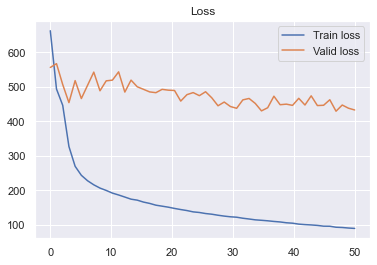

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt 

#### Plotting training and Validation Loss 

sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

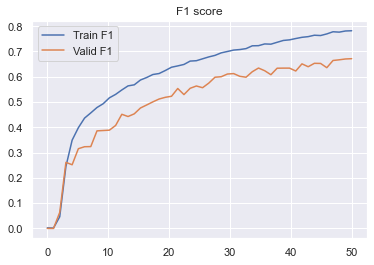

In [21]:
#### Plotting training and Validation F1 Score  

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

#### Loading the saved model on test set for prediction 

model.load_state_dict(torch.load('tut4-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, tags_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 556.174 |  Test F1 score: 56.35%


In [23]:
predict =  [item for sublist in preds for item in sublist]

true =  [item for sublist in labels for item in sublist]

confusion = confusion_matrix(true, predict)

### Confusion Matrix

In [24]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in tags.vocab.itos][1:]
s = pd.Series([i for i in tags.vocab.itos][1:])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in tags.vocab.itos if i != 'O' and i != '<pad>' ])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in tags.vocab.itos if i != 'O' and i != '<pad>' ])

confusion_df

,O,LOC,PER,ORG,MISC
O,38415,18,23,24,40
LOC,518,1232,65,84,25
PER,1865,10,866,25,6
ORG,1039,108,171,1097,79
MISC,409,6,19,25,456


### Calculation of Precision, Recall and F1Score

In [25]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.909317,0.997274,0.951267
LOC,0.896652,0.640333,0.747119
PER,0.756993,0.312410,0.442288
ORG,0.874104,0.439856,0.585223
MISC,0.752475,0.498361,0.599606


In [31]:
#### Visualize the attention weights

def visualize_attn(tokens, weights):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(weights, cmap=plt.get_cmap("gray"))
    ax.set_xticks(list(range(len(tokens))))
    ax.set_yticks(list(range(len(tokens))))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    # Create colorbar
    _ = ax.figure.colorbar(im, ax=ax)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
    plt.show()



In [27]:
#### Using model to predict for a given sentence


def tag_sentence(model, device, sentence, text_field, tag_field):
 
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.blank('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    
    predictions,_, attn_weight = model(token_tensor)
    visualize_attn(tokens, attn_weight.detach().cpu().numpy()[0])
    
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [33]:
example_index = 5


sentence = vars(valid_data.examples[example_index])['text']
actual_tags = vars(valid_data.examples[example_index])['tag']

print("sentence : ", sentence)
print("actual tags : ", actual_tags)

sentence :  ['After', 'bowling', 'Somerset', 'out', 'for', '83', 'on', 'the', 'opening', 'morning', 'at', 'Grace', 'Road', ',', 'Leicestershire', 'extended', 'their', 'first', 'innings', 'by', '94', 'runs', 'before', 'being', 'bowled', 'out', 'for', '296', 'with', 'England', 'discard', 'Andy', 'Caddick', 'taking', 'three', 'for', '83', '.']
actual tags :  ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
